<a href="https://colab.research.google.com/github/rdsmaia/dim0494/blob/main/imdb_lstm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras import models, layers, optimizers, losses, metrics, utils, datasets, callbacks

In [2]:
# constants and hyperparameters
hp = {
    'MAX_WORD_INDEX': 10000,
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 10,
    'LR': 0.001,
    'BETA1': 0.9,
    'BETA2': 0.999,
    'EPSILON': 1.0e-8,
    'DECAY': 0.0,
    'VAL_PERC': 0.4,
    'EMBEDDING_DIM': 64,
    'NUM_LSTM_UNITS': 32,
    'DROPOUT_RATE': 0.5
}

In [3]:
# load database using Keras
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words = hp['MAX_WORD_INDEX'])

In [4]:
#  print some information on the data
max_seq_len_train = max([len(sequence) for sequence in train_data])
max_seq_len_test = max([len(sequence) for sequence in test_data])
min_seq_len_train = min([len(sequence) for sequence in train_data])
min_seq_len_test = min([len(sequence) for sequence in test_data])
print(f'Maximum train sequence length: {max_seq_len_train}')
print(f'Maximum test sequence length: {max_seq_len_test}')
print(f'Minimum train sequence length: {min_seq_len_train}')
print(f'Minimum test sequence length: {min_seq_len_test}')

Maximum train sequence length: 2494
Maximum test sequence length: 2315
Minimum train sequence length: 11
Minimum test sequence length: 7


In [5]:
# randomly selects a sentence, look at the encoding and check its label
word_index = tf.keras.datasets.imdb.get_word_index()

ind = 33

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[ind]])

print(f'REVIEW:\n {decoded_review}\n')
print(f'Encoded sequence of words:\n {train_data[ind]}\n')
print(f'Label: {train_labels[ind]}\n')

REVIEW:
 ? i don't know what it is i find so endearing about this film but the first time i saw it i wanted to see how it ended i'm not a big fan of paul ? nor of war dramas but i was truly wondering just how and when ? would find his child all he knows is that the boy has green eyes truth be told i have not seen this movie in years nor has it been shown on tv in a while but this movie is somewhat of one man's odyssey after the pains of war ? shows a very sympathetic and heart warming portrayal of a man lost by his memories there is an underlying message in this movie that he is looking for the last shred of human morality in the aftermath of this war and the reality that he does confront why this movie is not yet on dvd or video is a mystery to me

Encoded sequence of words:
 [1, 13, 92, 124, 51, 12, 9, 13, 169, 38, 3308, 44, 14, 22, 21, 4, 86, 58, 13, 219, 12, 13, 473, 8, 67, 89, 12, 1054, 146, 24, 6, 194, 337, 7, 723, 2, 885, 7, 325, 3287, 21, 13, 16, 371, 1535, 43, 89, 5, 54, 2, 62

In [8]:
# pad sequences
X_train = tf.keras.utils.pad_sequences(train_data)
X_test = tf.keras.utils.pad_sequences(test_data, maxlen=X_train.shape[1])
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (25000, 2494)
X_test shape: (25000, 2494)


In [9]:
# transform labels  into arrays
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (25000,)
y_test shape: (25000,)


In [10]:
# split training data into training and validation
nsamples = X_train.shape[0]
nval_samples = int(hp['VAL_PERC'] * nsamples)
X_val = X_train[:nval_samples]
partial_X_train = X_train[nval_samples:]
y_val = y_train[:nval_samples]
partial_y_train = y_train[nval_samples:]

In [11]:
# build model
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(hp['MAX_WORD_INDEX'], hp['EMBEDDING_DIM']))
model1.add(tf.keras.layers.LSTM(
    units=hp['NUM_LSTM_UNITS'],
    ))
model1.add(tf.keras.layers.Dropout(rate=hp['DROPOUT_RATE']))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 652449 (2.49 MB)
Trainable params: 652449 (2.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=hp['LR'],
                      beta_1=hp['BETA1'],
                      beta_2=hp['BETA2'],
                      epsilon=hp['EPSILON'],
                      weight_decay=hp['DECAY'])

In [13]:
# set loss and metrics
loss = tf.keras.losses.binary_crossentropy
met = [tf.keras.metrics.binary_accuracy]

In [14]:
# compile model: optimization method, training criterion and metrics
model1.compile(
    optimizer=opt,
    loss=loss,
    metrics=met
    )

In [16]:
# early stop
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='binary_accuracy',
        patience=5),
    ]

In [17]:
# train model
history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=hp['NUM_EPOCHS'],
                    batch_size=hp['BATCH_SIZE'],
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/10
118/118 [==============================] - 43s 330ms/step - loss: 0.5935 - binary_accuracy: 0.6977 - val_loss: 0.3945 - val_binary_accuracy: 0.8312
Epoch 2/10
118/118 [==============================] - 33s 276ms/step - loss: 0.3108 - binary_accuracy: 0.8781 - val_loss: 0.3065 - val_binary_accuracy: 0.8716
Epoch 3/10
118/118 [==============================] - 27s 225ms/step - loss: 0.2098 - binary_accuracy: 0.9277 - val_loss: 0.3185 - val_binary_accuracy: 0.8702
Epoch 4/10
118/118 [==============================] - 25s 215ms/step - loss: 0.1463 - binary_accuracy: 0.9524 - val_loss: 0.3470 - val_binary_accuracy: 0.8636
Epoch 5/10
118/118 [==============================] - 22s 190ms/step - loss: 0.1056 - binary_accuracy: 0.9686 - val_loss: 0.4678 - val_binary_accuracy: 0.8626
Epoch 6/10
118/118 [==============================] - 21s 177ms/step - loss: 0.0825 - binary_accuracy: 0.9764 - val_loss: 0.4433 - val_binary_accuracy: 0.8648
Epoch 7/10
118/118 [==========================

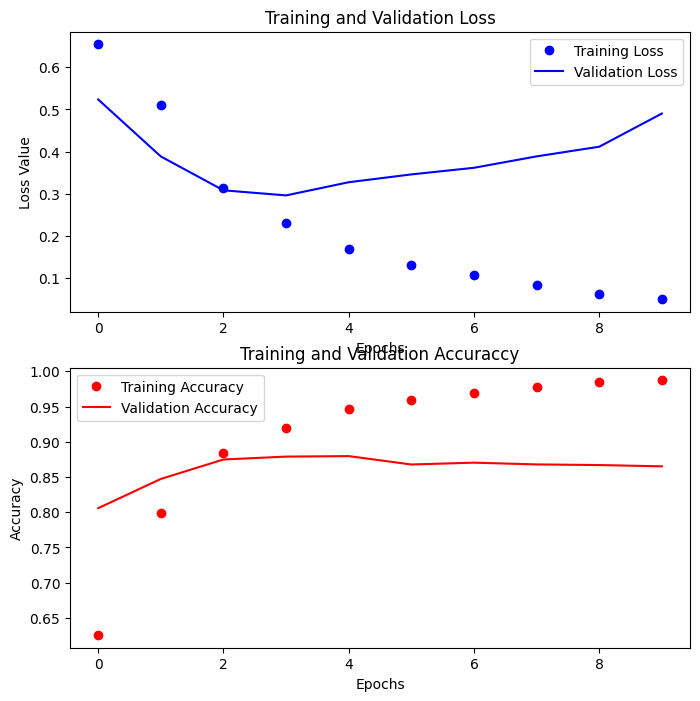

In [18]:
# learning curves
history_dict = history.history
history_dict.keys()

# losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# accuracies
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(hp['NUM_EPOCHS'])

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(epochs, loss_values, 'bo', label="Training Loss")
ax1.plot(epochs, val_loss_values, 'b', label="Validation Loss")
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss Value')
ax1.legend()

ax2.plot(epochs, acc_values, 'ro', label="Training Accuracy")
ax2.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
ax2.set_title('Training and Validation Accuraccy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
# testing model
y_test_hat = model1.predict()